In [1]:
%matplotlib inline

# 你眼中的風景

###測試於tensorflow 1.10  keras 2.2.2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from keras.models import *
from keras.layers import * 
from keras.losses import * 
from keras.callbacks import *
from keras.preprocessing import image
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.applications import * 
from keras.applications.imagenet_utils import *
from keras.utils.np_utils import to_categorical
from keras.optimizers import  Adam
import _cntk_py
import pickle
import skimage.io
import skimage.transform
import skimage.filters
import cv2

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.40
set_session(tf.Session(config=config))

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

Using TensorFlow backend.


In [3]:
model = VGG16(weights='imagenet')
layer_dict={}


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
def normalize(image):

    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def k_normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11, 11 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image =normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1
        


In [ ]:
img_path = '../Images/pig.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.axis('off')
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('輸入圖片shape:', x.shape)



In [6]:
preds = model.predict(x)
print('預測結果為:', decode_predictions(preds))
print('實際答案是:Pembroke柯基')


label_index = np.argmax(preds)
print("label index: ", label_index)

預測結果為: [[('n02113023', 'Pembroke', 0.69156736), ('n02113186', 'Cardigan', 0.30640975), ('n02110806', 'basenji', 0.0003824342), ('n02109961', 'Eskimo_dog', 0.0003449773), ('n02115641', 'dingo', 0.00024280683)]]
實際答案是:Pembroke柯基
label index:  263


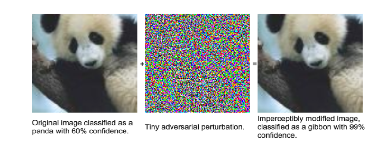

In [7]:
plt.axis('off')
plt.imshow(image.load_img('../Images/FewPixelsAttack.png',target_size=(360,900)))

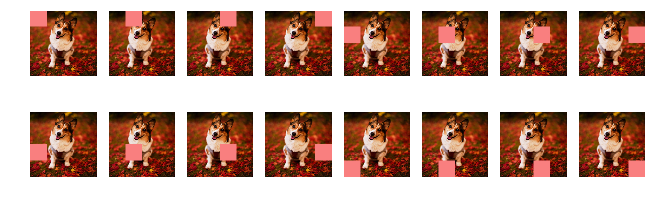

In [8]:
step = 56
heatmap_x = []
img = image.load_img(img_path, target_size=(224, 224))
x_arr = image.img_to_array(img)
for row in range(0, x_arr.shape[0], step):
    for col in range(0, x_arr.shape[1], step):
        new_image = x_arr.copy()#
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

display_images(heatmap_x, cols=8)

(16, 1000)
[263 264 263 263 263 263 263 263 263 263 263 263 263 263 263 263]
[('n02113023', 'Pembroke', 0.69535637), ('n02113186', 'Cardigan', 0.6217631), ('n02113023', 'Pembroke', 0.6932256), ('n02113023', 'Pembroke', 0.73000443), ('n02113023', 'Pembroke', 0.7776913), ('n02113023', 'Pembroke', 0.79772633), ('n02113023', 'Pembroke', 0.798366), ('n02113023', 'Pembroke', 0.7782367), ('n02113023', 'Pembroke', 0.7716653), ('n02113023', 'Pembroke', 0.8786304), ('n02113023', 'Pembroke', 0.8437393), ('n02113023', 'Pembroke', 0.77089113), ('n02113023', 'Pembroke', 0.72932917), ('n02113023', 'Pembroke', 0.8170084), ('n02113023', 'Pembroke', 0.7549553), ('n02113023', 'Pembroke', 0.7220447)]
什麼!!說我是羊毛衫??


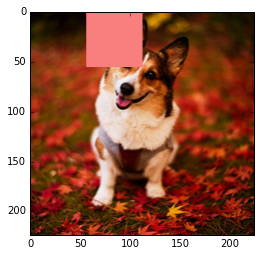

In [9]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
print(heatmap_y.shape)
print(np.argmax(heatmap_y,-1))
predodds=decode_predictions(heatmap_y)
predodds1=[y[0] for y in predodds]
#print(predodds.shape)
print(predodds1)

plt.imshow(normalize(heatmap_x[1]))
print('什麼!!說我是羊毛衫??')

[[0.36521885 1.         0.3694649  0.29617402]
 [0.20114613 0.16122137 0.15994667 0.20005932]
 [0.21315448 0.         0.06952921 0.21469715]
 [0.29751965 0.12279713 0.24645326 0.31203574]]


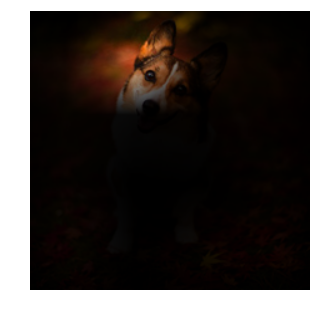

In [10]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
probs = heatmap_y[:, label_index]
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
print(heatmap)
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    display_images([image_heatmap], cols=2)
    
apply_mask(x_arr, heatmap**2)

shape: (1, 224, 224, 64)  min: 0.0  max: 724.563232421875


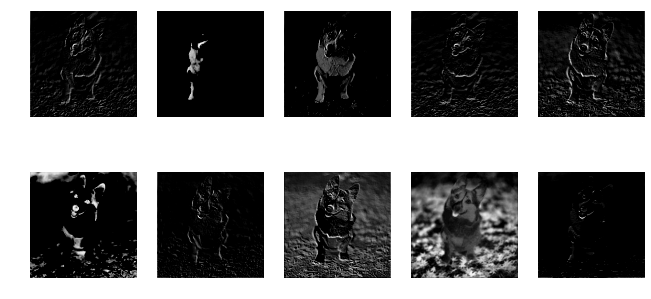

In [11]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))
    
def read_layer(model, x, layer_name):
    """回傳指定神經層的活化值"""
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

    
x_process = np.expand_dims(x_arr, axis=0)
x_process = preprocess_input(x_process)
view_layer(model,x, "block1_conv1")

shape: (1, 224, 224, 64)  min: 0.0  max: 724.563232421875


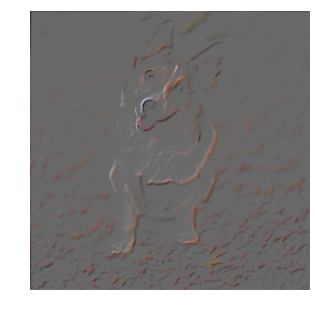

In [12]:
a = read_layer(model, x_process, "block1_conv1")
apply_mask(x_arr, a[:,:,0])

shape: (1, 224, 224, 64)  min: 0.0  max: 2827.398193359375


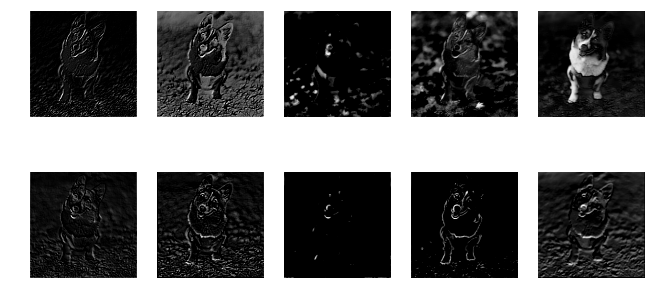

In [13]:
view_layer(model, x_process, "block1_conv2")

shape: (1, 112, 112, 128)  min: 0.0  max: 4921.6337890625


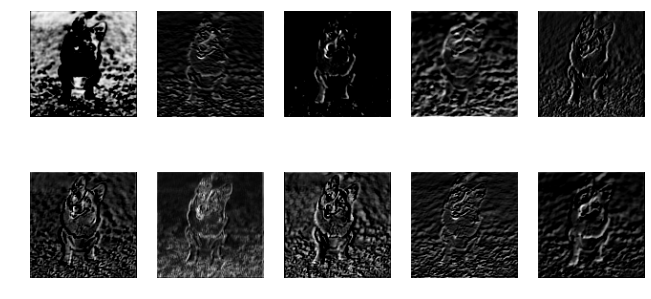

In [14]:
view_layer(model, x_process, "block2_conv1")

shape: (1, 56, 56, 256)  min: 0.0  max: 11647.0283203125


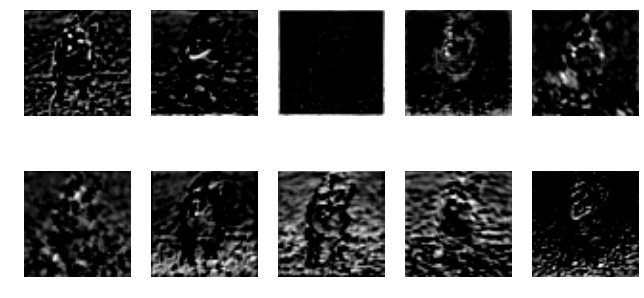

In [15]:
view_layer(model, x_process, "block3_conv1")

shape: (1, 28, 28, 512)  min: 0.0  max: 6818.357421875


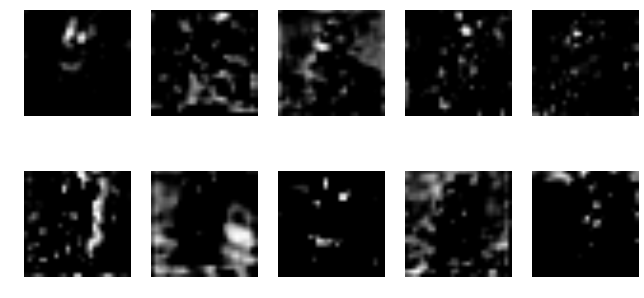

In [16]:
view_layer(model, x_process, "block4_conv2")

shape: (1, 28, 28, 512)  min: 0.0  max: 6818.357421875


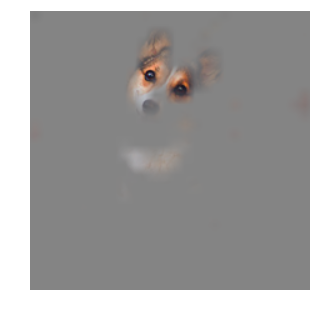

In [17]:
a = read_layer(model, x_process, "block4_conv2")
apply_mask(x_arr, a[:,:,0])

shape: (1, 14, 14, 512)  min: 0.0  max: 452.94189453125


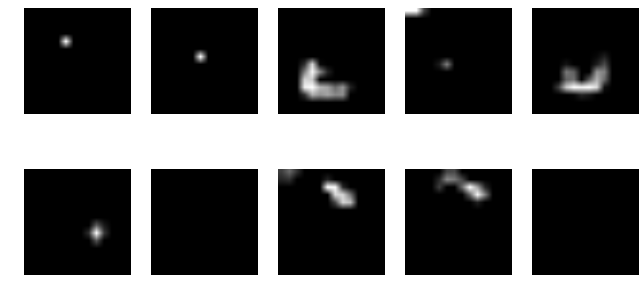

In [18]:
view_layer(model, x_process, "block5_conv3")

shape: (1, 14, 14, 512)  min: 0.0  max: 452.94189453125


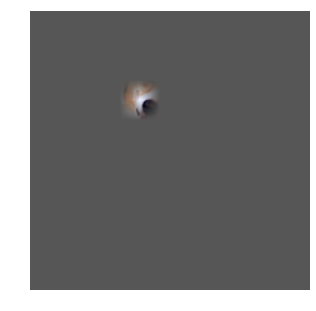

In [19]:
a = read_layer(model, x_process, "block5_conv3")
apply_mask(x_arr, a[:,:,0])




## Grad-CAM(Class Activation Maps)

conv_outputs:(14, 14, 512)
grads_val:(14, 14, 512)
weights:(512,)
cam:(14, 14)


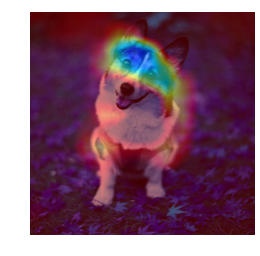

In [20]:

#計算指定標籤的損失函數
def target_category_loss(x, category_index, nb_classes):
    return categorical_crossentropy(K.one_hot([category_index], nb_classes),x)

#計算Grad CAM
def grad_cam(input_model, orig_image_path, layer_name='block5_conv3',category_index=263, nb_classes=1000):
    
    nb_classes = 1000
    category_index=263
    layer_dict = dict([(layer.name, layer) for layer in input_model.layers])
    
    x_arr = cv2.imread(orig_image_path)
    x_arr = cv2.resize(x_arr, (224, 224))
    x_process = np.expand_dims(x_arr, axis=0)
    x_process = preprocess_input(x_process)


    loss=target_category_loss(layer_dict['predictions'].output,category_index,nb_classes)
    grads = k_normalize(K.gradients(loss, layer_dict[layer_name].output)[0])
    gradient_function = K.function([input_model.input, K.learning_phase()], [layer_dict[layer_name].output,grads])  
    conv_outputs,grads_val = gradient_function([x_process])
    
    grads_val=np.asarray(grads_val)[0, :, :, :]
    conv_outputs = conv_outputs[0, :, :, :]

    print('conv_outputs:{0}'.format(conv_outputs.shape))
    print('grads_val:{0}'.format(grads_val.shape))
    weights= np.mean(grads_val, axis = (0, 1))
    print('weights:{0}'.format(weights.shape))

    cam = np.ones(conv_outputs.shape[0 : 2], dtype = np.float32)
    print('cam:{0}'.format(cam.shape))
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    
    resized_cam = cv2.resize(cam, (224, 224))
    resized_cam = np.maximum(resized_cam, 0)
    heatmap = resized_cam / np.max(resized_cam)
    final_cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    
    
    
    final_cam = np.float32(final_cam) + np.float32(x_arr)
    final_cam = 255 * final_cam / np.max(final_cam)
    return np.uint8(final_cam), heatmap



final_cam, heatmap = grad_cam(model, '../Images/dog.jpg',"block5_conv3",263,1000)

#cv2.cvtColor(final_cam, cv2.COLOR_BGR2RGB)
cv2.imwrite('Models/heatmap.jpg', final_cam)
plt.imshow(final_cam)
plt.axis('off')
plt.show()

conv_outputs:(14, 14, 512)
grads_val:(14, 14, 512)
weights:(512,)
cam:(14, 14)


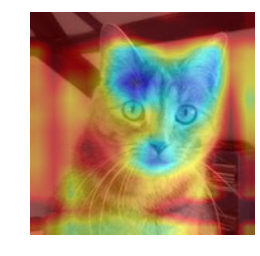

In [21]:
cat_final_cam, cat_heatmap = grad_cam(model, '../Images/cat.jpg',"block5_conv3",285,1000)

#cv2.cvtColor(cat_final_cam, cv2.COLOR_BGR2RGB)
cv2.imwrite('Models/heatmap_cat.jpg', cat_final_cam)
plt.imshow(cat_final_cam)
plt.axis('off')
plt.show()
